## Chapter 10 : Modern RNN
- **LSTM**
  - The structure is :
  - <img alt="LSTM Arch" src="https://zh.d2l.ai/_images/lstm-3.svg" style="background-color: white; display: inline-block;"> LSTM Arch
- **GRU**
  - <img alt="GRU Arch" src="https://d2l.ai/_images/gru-3.svg" style="background-color: white; display: inline-block;"> GRU Arch
  - Reset gates help capture short-term dependencies in sequences.
  - Update gates help capture long-term dependencies in sequences.
- **Deep RNN**
  - <img alt="Deep RNN" src="https://d2l.ai/_images/deep-rnn.svg" style="background-color: white; display: inline-block;"> Deep RNN
  - In deep rnn, the output is the last layer of the hidden state with every timestep, and state is the last time step hidden state with all layer of rnn.
- **Bidirection RNN**, it is slow and gradient chain is long
  - $P(x_1,\ldots,x_T,h_1,\ldots,h_T)=\prod_{t=1}^TP(h_t\mid h_{t-1})P(x_t\mid h_t),\mathrm{~where~}P(h_1\mid h_0)=P(h_1)$, it is a hidden markov model. We can use dynamic programming method compute is from start to end, also from end to start. Just how B-RNN is capable of.
  - <img alt="Bidirection RNN" src="https://zh.d2l.ai/_images/birnn.svg" style="background-color: white; display: inline-block;"> B-RNN
  - And we just need to concatenate these two H.
- **Machine translation**
  - non-breaking space, some space should not split to new line, like Mr. Smith.
  - Teacher Forcing : all the input will be pad with \<pad\>, source token no special treat, decoder input (target seq use as input) will start with \<bos\>, and label is shift by 1 (no \<bos\> at the begining).
  - **Important**: when use teacher forcing, the truth target is feed to the decoder. This will make the traning faster and stable, but it will make training and predicting different (because when predicting we do not have truth target label, we have to repeatedly predict). We can make them the same, but the tranning will be harder.
- **Sequence to Sequence**
  - We use this Encoder - Decoder Arch to get varied length input and varied length output.
  - We do not use one-hot, instead we use nn.Embed layer, which will take token i, and return ith row of the matrix of this embeding layer.
  - From the encoder, we get the hidden states, and use a funcion $c = q(h_1, \cdots, h_T)$, for example, just use the $h_T$. And in the decoder, we concatenate this with the target embed output, and feed to rnn.
  - When calculating the loss, we should not take \<pad\> into acount. So we need to musk the loss with the tokens.
  - <img alt="Encoder Decoder" src="https://d2l.ai/_images/seq2seq-details.svg" style="background-color: white; display: inline-block;"> Encoder Decoder
  - Bilingual Evaluation Understudy, BLEU evaluates whether this n-gram in the predicted sequence appears in the target sequence. For example, target sequence ABCDEF, predict sequence ABBCD, $p_1 = 4/5$, we have ABCD in the target sequence, $p_2 = 3 / 4$, we have AB, BC, CD. So we get BLEU as $\exp\left(\min\left(0,1-\frac{\mathrm{len}_{\mathrm{label}}}{\mathrm{len}_{\mathrm{pred}}}\right)\right)\prod_{n=1}^kp_n^{1/2^n}$, higher n will have higher weight, small length of predict length takes lower.
- **Beam Search**
  - Before this section, we use greedy search to get prediction, use argmax on the prediction vector : $y_{t^{\prime}}=\underset{y\in\mathcal{Y}}{\operatorname*{\operatorname*{argmax}}}P(y\mid y_1,\ldots,y_{t^{\prime}-1},\mathbf{c})$, where $\mathcal Y$ is the vacab. Once our model outputs “<eos>” (or we reach the maximum length $T'$) the output sequence is completed.
  - However, use the most likely tokens is not the same with the most likely sequence : $\prod_{t^{\prime}=1}^{T^{\prime}}P(y_{t^{\prime}}\mid y_1,\ldots,y_{t^{\prime}-1},\mathbf{c})$. For example, in this figure below, ACB will have this probability of 0.5 * 0.3 * 0.6 = 0.09. On the other hand, greedy search choose ABC which is 0.5 * 0.4 * 0.4 = 0.08, it is lower, not optimal!
  - <img alt="Max sequence" src="https://d2l.ai/_images/s2s-prob2.svg" style="background-color: white; display: inline-block;">Max sequence <img alt="Max token" src="https://d2l.ai/_images/s2s-prob1.svg" style="background-color: white; display: inline-block;"> Max token.
  - If we want the optimal one, we need to do exhaustive search, search all possible sequence, it is not possible!
  - The most straightforward type of beam search is keep k candidates. In time step 2, we get $P ( A, y_{2} \mid\mathbf{c} )=P ( A \mid\mathbf{c} ) P ( y_{2} \mid A, \mathbf{c} )$ for the top, and $P ( C, y_{2} \mid\mathbf{c} )=P ( C \mid\mathbf{c} ) P ( y_{2} \mid C, \mathbf{c} ) $ for the bottom, then choose most 2 from them. And then choose sequence that maximize $\frac{1} {L^{\alpha}} \mathrm{l o g} \, P ( y_{1}, \ldots, y_{L} \mid\mathbf{c} )=\frac{1} {L^{\alpha}} \sum_{t^{\prime}=1}^{L} \mathrm{l o g} \, P ( y_{t^{\prime}} \mid y_{1}, \ldots, y_{t^{\prime}-1}, \mathbf{c} ) ; $. Note tha we have **6** candidates (A, C ..).
  - <img alt="Max sequence" src="https://d2l.ai/_images/beam-search.svg" style="background-color: white; display: inline-block;">
<!-- <img alt="ResNeXt Block" src="https://d2l.ai/_images/rnn.svg" style="background-color: white; display: inline-block;"> -->
<!-- <img alt="ResNeXt Block" src="https://d2l.ai/_images/rnn-bptt.svg" style="background-color: white; display: inline-block;"> -->

In [4]:
import collections
import math
import torch
from torch import nn
from torch.nn import functional as F
from torchinfo import summary
import matplotlib.pyplot as plt

In [ ]:
"""
Define a LSTM model here
"""

class LSTMScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()

        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
        triple = lambda: (init_weight(num_inputs, num_hiddens),
                          init_weight(num_hiddens, num_hiddens),
                          nn.Parameter(torch.zeros(num_hiddens)))
        self.W_xi, self.W_hi, self.b_i = triple()  # Input gate
        self.W_xf, self.W_hf, self.b_f = triple()  # Forget gate
        self.W_xo, self.W_ho, self.b_o = triple()  # Output gate
        self.W_xc, self.W_hc, self.b_c = triple()  # Input node

    def forward(self, inputs, H_C=None):
        if H_C is None:
            # Initial state with shape: (batch_size, num_hiddens)
            H = torch.zeros((inputs.shape[1], self.num_hiddens),
                          device=inputs.device)
            C = torch.zeros((inputs.shape[1], self.num_hiddens),
                          device=inputs.device)
        else:
            H, C = H_C
        outputs = []
        for X in inputs:
            I = torch.sigmoid(torch.matmul(X, self.W_xi) +
                            torch.matmul(H, self.W_hi) + self.b_i)
            F = torch.sigmoid(torch.matmul(X, self.W_xf) +
                            torch.matmul(H, self.W_hf) + self.b_f)
            O = torch.sigmoid(torch.matmul(X, self.W_xo) +
                            torch.matmul(H, self.W_ho) + self.b_o)
            C_tilde = torch.tanh(torch.matmul(X, self.W_xc) +
                               torch.matmul(H, self.W_hc) + self.b_c)
            C = F * C + I * C_tilde # This is important, use F to forget, I to input
            H = O * torch.tanh(C)
            outputs.append(H)
        return outputs, (H, C)

In [ ]:
"""
Define a GRU model here
"""

class GRUScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()

        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
        triple = lambda: (init_weight(num_inputs, num_hiddens),
                          init_weight(num_hiddens, num_hiddens),
                          nn.Parameter(torch.zeros(num_hiddens)))
        self.W_xz, self.W_hz, self.b_z = triple()  # Update gate
        self.W_xr, self.W_hr, self.b_r = triple()  # Reset gate
        self.W_xh, self.W_hh, self.b_h = triple()  # Candidate hidden state

    def forward(self, inputs, H=None):
        if H is None:
            # Initial state with shape: (batch_size, num_hiddens)
            H = torch.zeros((inputs.shape[1], self.num_hiddens),
                          device=inputs.device)
        outputs = []
        for X in inputs:
            Z = torch.sigmoid(torch.matmul(X, self.W_xz) +
                            torch.matmul(H, self.W_hz) + self.b_z)
            R = torch.sigmoid(torch.matmul(X, self.W_xr) +
                            torch.matmul(H, self.W_hr) + self.b_r)
            H_tilde = torch.tanh(torch.matmul(X, self.W_xh) +
                               torch.matmul(R * H, self.W_hh) + self.b_h)
            H = Z * H + (1 - Z) * H_tilde
            outputs.append(H)
        return outputs, H

In [4]:
lstm_model = nn.LSTM(28, 32) # 28 is one-hot size, 32 is hidden size
summary(lstm_model, input_size = (10, 16, 28)) # 10 is squence length (time step), 16 is batch size

Layer (type:depth-idx)                   Output Shape              Param #
LSTM                                     [10, 16, 32]              7,936
Total params: 7,936
Trainable params: 7,936
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.27
Input size (MB): 0.02
Forward/backward pass size (MB): 0.04
Params size (MB): 0.03
Estimated Total Size (MB): 0.09

In [5]:
rnn_model = nn.RNN(28, 32) # param size is exaclty 1 / 4 of lstm
summary(rnn_model, input_size = (10, 16, 28))

Layer (type:depth-idx)                   Output Shape              Param #
RNN                                      [10, 16, 32]              1,984
Total params: 1,984
Trainable params: 1,984
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.32
Input size (MB): 0.02
Forward/backward pass size (MB): 0.04
Params size (MB): 0.01
Estimated Total Size (MB): 0.07

In [6]:
gru_model = nn.GRU(28, 32) # 3 times of RNN
summary(gru_model, input_size = (10, 16, 28))

Layer (type:depth-idx)                   Output Shape              Param #
GRU                                      [10, 16, 32]              5,952
Total params: 5,952
Trainable params: 5,952
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.95
Input size (MB): 0.02
Forward/backward pass size (MB): 0.04
Params size (MB): 0.02
Estimated Total Size (MB): 0.08

In [8]:
rnn_deep_model = nn.RNN(28, 32, 2) # a little bigger than 2 times of noraml RNN
summary(rnn_deep_model, input_size = (10, 16, 28), depth = 3)

Layer (type:depth-idx)                   Output Shape              Param #
RNN                                      [10, 16, 32]              4,096
Total params: 4,096
Trainable params: 4,096
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.66
Input size (MB): 0.02
Forward/backward pass size (MB): 0.04
Params size (MB): 0.02
Estimated Total Size (MB): 0.08

In [10]:
rnn_bidirect_model = nn.RNN(28, 32, bidirectional = True) # 2 time of normal RNN
summary(rnn_bidirect_model, input_size = (10, 16, 28), depth = 3)

Layer (type:depth-idx)                   Output Shape              Param #
RNN                                      [10, 16, 64]              3,968
Total params: 3,968
Trainable params: 3,968
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.63
Input size (MB): 0.02
Forward/backward pass size (MB): 0.08
Params size (MB): 0.02
Estimated Total Size (MB): 0.12

In [2]:
class Vocab:
    """Vocabulary for text."""
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        """Defined in :numref:`sec_text-sequence`"""
        # Flatten a 2D list if needed
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        # Count token frequencies
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        # The list of unique tokens
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [
            token for token, freq in self.token_freqs if freq >= min_freq])))
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]

    @property
    def unk(self):  # Index for the unknown token
        return self.token_to_idx['<unk>']
        
class MyData:
    def __init__(self, batch_size, num_steps=9, num_train=512, num_val=128):
        super().__init__()
        self.batch_size = batch_size
        self.num_steps = num_steps
        self.num_train = num_train
        self.num_val = num_val
        self.arrays, self.src_vocab, self.tgt_vocab = self._build_arrays(
            self._read_data())
        
    def _read_data(self, path = "../../Data/fra-eng/fra.txt"):
        with open(path, encoding='utf-8') as f:
            return f.read()
    
    def _preprocess(self, text):
        # Replace non-breaking space with space
        text = text.replace('\u202f', ' ').replace('\xa0', ' ')
        # Insert space between words and punctuation marks
        no_space = lambda char, prev_char: char in ',.!?' and prev_char != ' '
        out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
               for i, char in enumerate(text.lower())]
        return ''.join(out)
    
    def _tokenize(self, text, max_examples=None):
        src, tgt = [], []
        for i, line in enumerate(text.split('\n')):
            if max_examples and i > max_examples: break
            parts = line.split('\t')
            if len(parts) == 2:
                # Skip empty tokens
                src.append([t for t in f'{parts[0]} <eos>'.split(' ') if t])
                tgt.append([t for t in f'{parts[1]} <eos>'.split(' ') if t])
        return src, tgt

    def _build_arrays(self, raw_text, src_vocab=None, tgt_vocab=None):
        def _build_array(sentences, vocab, is_tgt=False):
            pad_or_trim = lambda seq, t: (
                seq[:t] if len(seq) > t else seq + ['<pad>'] * (t - len(seq)))
            sentences = [pad_or_trim(s, self.num_steps) for s in sentences]
            if is_tgt:
                sentences = [['<bos>'] + s for s in sentences] # tgt length will be longer
            if vocab is None:
                vocab = Vocab(sentences, min_freq=2)
            array = torch.tensor([vocab[s] for s in sentences])
            valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1) # this is needed
            return array, vocab, valid_len
        src, tgt = self._tokenize(self._preprocess(raw_text),
                                  self.num_train + self.num_val)
        src_array, src_vocab, src_valid_len = _build_array(src, src_vocab)
        tgt_array, tgt_vocab, _ = _build_array(tgt, tgt_vocab, True)
        return ((src_array, tgt_array[:,:-1], src_valid_len, tgt_array[:,1:]),
                src_vocab, tgt_vocab)

    def train_dataloader(self):
        return self.get_dataloader(train=True)

    def val_dataloader(self):
        return self.get_dataloader(train=False)

    def get_tensorloader(self, tensors, train, indices=slice(0, None)):
        """Defined in :numref:`sec_synthetic-regression-data`"""
        tensors = tuple(a[indices] for a in tensors)
        dataset = torch.utils.data.TensorDataset(*tensors)
        return torch.utils.data.DataLoader(dataset, self.batch_size,
                                           shuffle=train)
        
    def get_dataloader(self, train):
        idx = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader(self.arrays, train, idx)

    def build(self, src_sentences, tgt_sentences):
        raw_text = '\n'.join([src + '\t' + tgt for src, tgt in zip(
            src_sentences, tgt_sentences)])
        arrays, _, _ = self._build_arrays(
            raw_text, self.src_vocab, self.tgt_vocab)
        return arrays

def show_list_len_pair_hist(legend, xlabel, ylabel, xlist, ylist):
    """Plot the histogram for list length pairs."""
    _, _, patches = plt.hist(
        [[len(l) for l in xlist], [len(l) for l in ylist]])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    for patch in patches[1].patches:
        patch.set_hatch('/')
    plt.legend(legend)

In [24]:
data = MyData()
raw_text = data.read_data("../../Data/fra-eng/fra.txt")
text = data._preprocess(raw_text)
src, tgt = data._tokenize(text)
print(text[:75])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça al


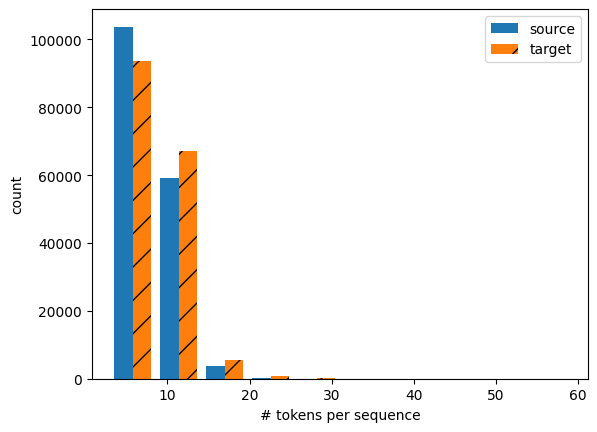

In [25]:
show_list_len_pair_hist(['source', 'target'], '# tokens per sequence',
                        'count', src, tgt);

In [3]:
data = MyData(batch_size=3)
src, tgt, src_valid_len, label = next(iter(data.train_dataloader()))
print('source:', src.type(torch.int32))
print('decoder input:', tgt.type(torch.int32))
print('source len excluding pad:', src_valid_len.type(torch.int32))
print('label:', label.type(torch.int32))

source: tensor([[188,   6,   3,   4,   4,   4,   4,   4,   4],
        [ 86,  43,   2,   3,   4,   4,   4,   4,   4],
        [  5,   0,   3,   4,   4,   4,   4,   4,   4]], dtype=torch.int32)
decoder input: tensor([[  3, 161,   7,   4,   5,   5,   5,   5,   5],
        [  3, 108, 183,  98,   2,   4,   5,   5,   5],
        [  3, 211,   6,   0,   4,   5,   5,   5,   5]], dtype=torch.int32)
source len excluding pad: tensor([3, 4, 3], dtype=torch.int32)
label: tensor([[161,   7,   4,   5,   5,   5,   5,   5,   5],
        [108, 183,  98,   2,   4,   5,   5,   5,   5],
        [211,   6,   0,   4,   5,   5,   5,   5,   5]], dtype=torch.int32)


In [5]:
data.tgt_vocab.idx_to_token[3], data.tgt_vocab.idx_to_token[5], data.src_vocab.idx_to_token[3]

('<bos>', '<pad>', '<eos>')

In [49]:
src, tgt, _,  _ = data.build(['hi .'], ['salut .'])
print('source:', data.src_vocab.to_tokens(src[0].type(torch.int32)))
print('target:', data.tgt_vocab.to_tokens(tgt[0].type(torch.int32)))

source: ['hi', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
target: ['<bos>', 'salut', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [6]:
"""
Encoder
"""

class Encoder(nn.Module):  #@save
    """The base encoder interface for the encoder--decoder architecture."""
    def __init__(self):
        super().__init__()

    # Later there can be additional arguments (e.g., length excluding padding)
    def forward(self, X, *args):
        raise NotImplementedError


In [7]:
"""
Decoder
"""

class Decoder(nn.Module):  #@save
    """The base decoder interface for the encoder--decoder architecture."""
    def __init__(self):
        super().__init__()

    # Later there can be additional arguments (e.g., length excluding padding)
    def init_state(self, enc_all_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError



In [8]:
"""
Encode - Decoder Arch
"""

argmax = lambda x, *args, **kwargs: x.argmax(*args, **kwargs)
astype = lambda x, *args, **kwargs: x.type(*args, **kwargs)
reduce_mean = lambda x, *args, **kwargs: x.mean(*args, **kwargs)

class Classifier(nn.Module):
    """The base class of classification models.

    Defined in :numref:`sec_classification`"""
    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
        self.plot('acc', self.accuracy(Y_hat, batch[-1]), train=False)

    def accuracy(self, Y_hat, Y, averaged=True):
        """Compute the number of correct predictions.
    
        Defined in :numref:`sec_classification`"""
        Y_hat = torch.reshape(Y_hat, (-1, Y_hat.shape[-1]))
        preds = astype(argmax(Y_hat, axis=1), Y.dtype)
        compare = astype(preds == torch.reshape(Y, -1), torch.float32)
        return reduce_mean(compare) if averaged else compare

    def loss(self, Y_hat, Y, averaged=True):
        """Defined in :numref:`sec_softmax_concise`"""
        Y_hat = torch.reshape(Y_hat, (-1, Y_hat.shape[-1]))
        Y = torch.reshape(Y, (-1,))
        return F.cross_entropy(
            Y_hat, Y, reduction='mean' if averaged else 'none')

    def layer_summary(self, X_shape):
        """Defined in :numref:`sec_lenet`"""
        X = torch.randn(*X_shape)
        for layer in self.net:
            X = layer(X)
            print(layer.__class__.__name__, 'output shape:\t', X.shape)

class EncoderDecoder(Classifier):  #@save
    """The base class for the encoder--decoder architecture."""
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_all_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_all_outputs, *args)
        # Return decoder output only
        return self.decoder(dec_X, dec_state)[0]

    def predict_step(self, batch, device, num_steps,
                 save_attention_weights=False):
        batch = [a.to(device) for a in batch]
        src, tgt, src_valid_len, _ = batch
        enc_all_outputs = self.encoder(src, src_valid_len)
        dec_state = self.decoder.init_state(enc_all_outputs, src_valid_len)
        outputs, attention_weights = [tgt[:, (0)].unsqueeze(1), ], []
        for _ in range(num_steps):
            Y, dec_state = self.decoder(outputs[-1], dec_state) # output is a list!
            outputs.append(Y.argmax(2)) # Y is (batch, 1(step), vocab), so ouput is (batch, 1)
            # Save attention weights (to be covered later)
            if save_attention_weights:
                attention_weights.append(self.decoder.attention_weights)
        return torch.cat(outputs[1:], 1), attention_weights # do not return <pad>, and return (batch, step)

In [23]:
def init_seq2seq(module):  #@save
    """Initialize weights for sequence-to-sequence learning."""
    if type(module) == nn.Linear:
         nn.init.xavier_uniform_(module.weight)
    if type(module) == nn.GRU:
        for param in module._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])

class Seq2SeqEncoder(Encoder):  #@save
    """The RNN encoder for sequence-to-sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers, dropout = dropout)
        self.apply(init_seq2seq)

    def forward(self, X, *args):
        # X shape: (batch_size, num_steps)
        embs = self.embedding(X.t().type(torch.int64))
        # embs shape: (num_steps, batch_size, embed_size)
        outputs, state = self.rnn(embs)
        # outputs shape: (num_steps, batch_size, num_hiddens)
        # state shape: (num_layers, batch_size, num_hiddens)
        return outputs, state

class Seq2SeqDecoder(Decoder):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size+num_hiddens, num_hiddens,
                           num_layers, dropout = dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(init_seq2seq)

    def init_state(self, enc_all_outputs, *args):
        return enc_all_outputs

    def forward(self, X, state):
        # X shape: (batch_size, num_steps)
        # embs shape: (num_steps, batch_size, embed_size)
        embs = self.embedding(X.t().type(torch.int32))
        enc_output, hidden_state = state
        # context shape: (batch_size, num_hiddens)
        context = enc_output[-1]
        # Broadcast context to (num_steps, batch_size, num_hiddens)
        context = context.repeat(embs.shape[0], 1, 1)
        # Concat at the feature dimension
        embs_and_context = torch.cat((embs, context), -1)
        outputs, hidden_state = self.rnn(embs_and_context, hidden_state)
        outputs = self.dense(outputs).swapaxes(0, 1)
        # outputs shape: (batch_size, num_steps, vocab_size)
        # hidden_state shape: (num_layers, batch_size, num_hiddens)
        return outputs, [enc_output, hidden_state]

class Seq2Seq(EncoderDecoder):  #@save
    """The RNN encoder--decoder for sequence to sequence learning."""
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)
        self.encoder = encoder
        self.decoder = decoder
        self.tgt_pad = tgt_pad
        self.lr = lr

    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)

    def configure_optimizers(self):
        # Adam optimizer is used here
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def loss(self, Y_hat, Y):
        l = super().loss(Y_hat, Y, averaged=False)
        mask = (Y.reshape(-1) != self.tgt_pad).type(torch.float32)
        return (l * mask).sum() / mask.sum()


In [18]:
vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 9
encoder = Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
X = torch.zeros((batch_size, num_steps))
enc_outputs, enc_state = encoder(X)
print(enc_outputs.shape, enc_state.shape)

torch.Size([9, 4, 16]) torch.Size([2, 4, 16])


In [41]:
decoder = Seq2SeqDecoder(vocab_size, embed_size, num_hiddens, num_layers)
state = decoder.init_state(encoder(X))
dec_outputs, state = decoder(X, state)
print(dec_outputs.shape, state[0].shape, state[1].shape)

torch.Size([4, 9, 10]) torch.Size([9, 4, 16]) torch.Size([2, 4, 16])


In [24]:
seq2seq = Seq2Seq(encoder, decoder, 5, 0.01)

In [42]:
print(dec_outputs[0])
dec_outputs_loss = torch.reshape(dec_outputs, (-1, dec_outputs.shape[-1]))
print(dec_outputs_loss.shape)
print(dec_outputs_loss[0])

tensor([[ 5.1774e-03, -1.3611e-01,  6.0320e-02, -2.3777e-01,  1.2387e-01,
          1.7110e-02,  4.3592e-02, -2.2250e-01, -1.2387e-01,  4.6138e-02],
        [-5.8463e-02, -1.6122e-02,  1.6028e-02, -4.3072e-02,  1.2748e-01,
         -8.2334e-02,  1.7483e-01, -2.9459e-01, -2.0162e-01,  6.0619e-02],
        [-9.1908e-02,  4.3872e-02, -1.4242e-04,  4.0666e-02,  1.3917e-01,
         -1.3944e-01,  2.5276e-01, -3.1762e-01, -2.5067e-01,  8.6200e-02],
        [-1.1042e-01,  7.2683e-02, -3.7957e-03,  7.8237e-02,  1.4776e-01,
         -1.7278e-01,  2.9364e-01, -3.2229e-01, -2.8004e-01,  1.1303e-01],
        [-1.2128e-01,  8.6662e-02, -3.1796e-03,  9.6976e-02,  1.5228e-01,
         -1.9283e-01,  3.1392e-01, -3.2116e-01, -2.9649e-01,  1.3621e-01],
        [-1.2786e-01,  9.3677e-02, -1.6188e-03,  1.0680e-01,  1.5400e-01,
         -2.0560e-01,  3.2374e-01, -3.1839e-01, -3.0519e-01,  1.5406e-01],
        [-1.3198e-01,  9.7356e-02, -1.1450e-04,  1.1190e-01,  1.5404e-01,
         -2.1419e-01,  3.2832e-0

In [38]:
index = 0
print([tgt[:, (index)].unsqueeze(1), ])
print(tgt[:, (index)].shape)
print(tgt[:, (index)].unsqueeze(1).shape)
print((tgt[:, (index)].unsqueeze(1))[-1].shape)
print(tgt.shape)

[tensor([[3],
        [3],
        [3]])]
torch.Size([3])
torch.Size([3, 1])
torch.Size([1])
torch.Size([3, 9])


In [43]:
print(dec_outputs.argmax(2))
print(dec_outputs.argmax(2).shape)

tensor([[4, 6, 6, 6, 6, 6, 6, 6, 6],
        [4, 6, 6, 6, 6, 6, 6, 6, 6],
        [4, 6, 6, 6, 6, 6, 6, 6, 6],
        [4, 6, 6, 6, 6, 6, 6, 6, 6]])
torch.Size([4, 9])


In [ ]:
"""
BLEU 
"""
def bleu(pred_seq, label_seq, k):  #@save
    """Compute the BLEU."""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, min(k, len_pred) + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score